In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pygstat import boise_prior
import time
from scipy import io




In [2]:
DATA = io.loadmat('Project_BHRS.mat')
G = DATA['G_fat']
#x = DATA['x']
#y = DATA['y']
d_obs = DATA['traveltimes'].astype(float)
d_std = DATA['traveltimes_std'].astype(float)
nd = len(d_obs)
nx = DATA['nx'].flatten()[0].astype(int)
ny = DATA['ny'].flatten()[0].astype(int) 
nxy=nx*ny
x = DATA['x'].flatten()
y = DATA['y'].flatten()
sources = DATA['sources'].flatten()
receivers = DATA['receivers'].flatten()

Text(0.5, 1.0, 'One realization')

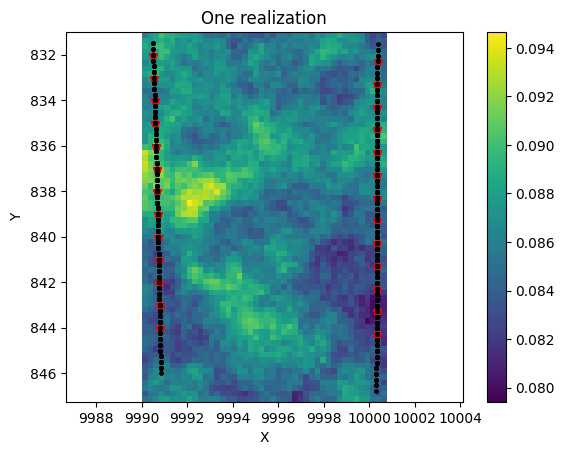

In [3]:

# Plot models and data
m, O = boise_prior()
plt.figure()
plt.imshow(m, extent=[x[0], x[-1], y[0], y[-1]])
plt.plot(DATA['sources'][:, 0], DATA['sources'][:, 1], 'r*')
plt.plot(DATA['receivers'][:, 0], DATA['receivers'][:, 1], 'k.', markersize=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.gca().invert_yaxis()
plt.axis('equal')
plt.title('One realization')

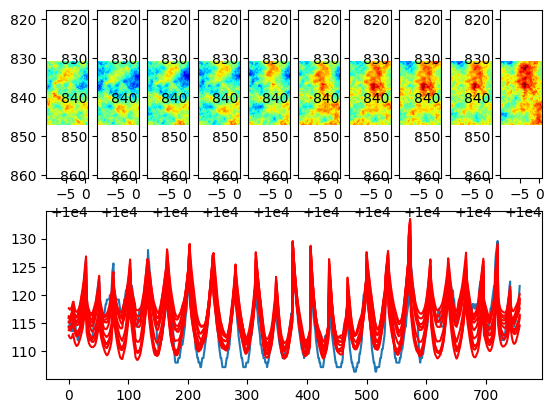

In [4]:
plt.figure()
plt.subplot(2, 1, 2)
plt.plot(d_obs.flatten())
for i in range(10):
    m, O = boise_prior(m, 0.3, O)

    d = G.dot(1.0 / m.flatten('F'))

    plt.subplot(2, 10, i+1)
    plt.imshow(m, extent=[x[0], x[-1], y[-1], y[0]], vmin=0.076, vmax=0.094, cmap='jet')
    plt.axis('equal')

    plt.subplot(2, 1, 2)
    plt.plot( d, 'r-')

plt.show()

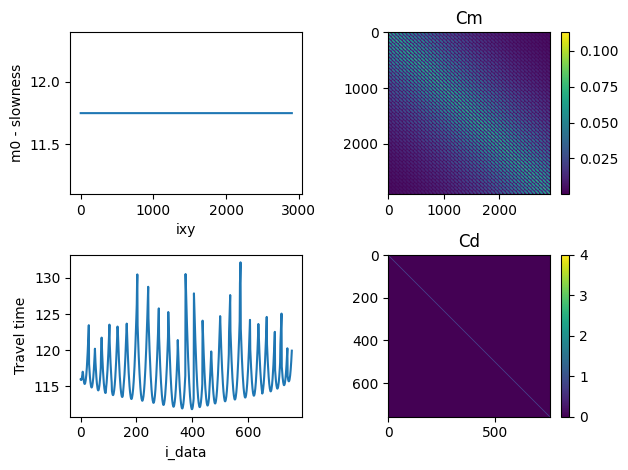

In [5]:

# N(m0,Cm) must refer to slowness
v0 = O['v0']
m0 = (np.ones((nxy,1)) * (1/v0))
Cm = (1/m).var()*O['Cm']/O['Cm'][0,0]
Cm_old = Cm.copy()

for i1 in range(nxy):
    for i2 in range(nxy):

        # convert i1 to (ix,iy), and convert (iy,ix) to i1_inv
        ix1 = i1 % nx
        iy1 = i1 // nx
        i1_inv = iy1 + ix1*ny

        ix2 = i2 % nx
        iy2 = i2 // nx
        i2_inv = iy2 + ix2*ny

        Cm[i1_inv,i2_inv] = Cm_old[i1,i2]

# Compute the diagonal Cm 
#Cm = np.diag(np.diag(Cm))

# N(d0,Cd) must refer to slowness
d0 = np.dot(G,m0) 
Cd = np.diag(d_std[:,0]**2)

plt.figure()
plt.subplot(2,2,1)
plt.plot(m0)
plt.xlabel('ixy')
plt.ylabel('m0 - slowness')
plt.subplot(2,2,2)
plt.imshow(Cm)
plt.title('Cm')
plt.colorbar()
plt.subplot(2,2,3)
plt.plot(d0)
plt.xlabel('i_data')
plt.ylabel('Travel time')
plt.subplot(2,2,4)
plt.imshow(Cd)
plt.title('Cd')
plt.colorbar()
plt.tight_layout()

Text(0.5, 1.0, 'Posterior std')

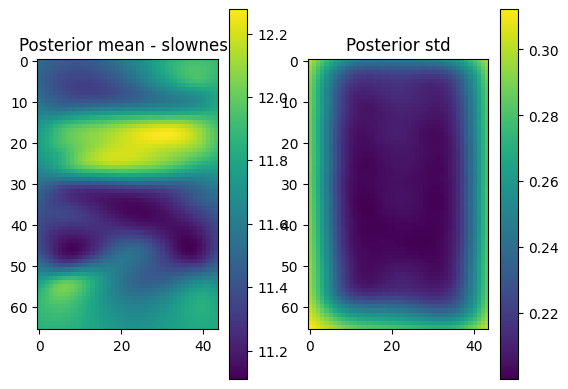

In [6]:
Gg_1 =  np.linalg.inv(np.dot(np.dot(G,Cm),G.T)+Cd)
Gg_2 = np.dot(np.dot(Cm,G.T),Gg_1)
m_est = m0 + np.dot(Gg_2, d_obs-np.dot(G,m0) )
Cm_est = Cm - np.dot(np.dot(Gg_2,G),Cm)

m_est_std = np.sqrt(np.diag(Cm_est))

m_est = m_est.reshape(nx,ny).T
m_est_std = m_est_std.reshape(nx,ny).T

plt.figure()
plt.subplot(1,2,1)
plt.imshow(m_est)
plt.title('Posterior mean - slowness')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(m_est_std)
plt.colorbar()
plt.title('Posterior std')

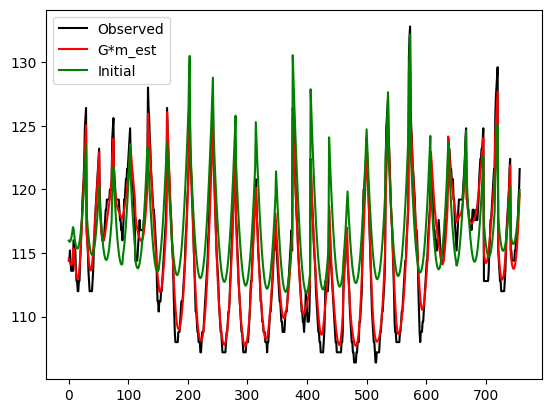

In [7]:
d_est = G.dot(m_est.flatten('F'))

plt.figure()
plt.plot(d_obs.flatten(), 'k-', label='Observed')
plt.plot(d_est, 'r-', label='G*m_est')
plt.plot(d0, 'g-', label='Initial')
plt.legend()

In [8]:
N=1000
m_post = np.zeros((ny, nx, N))

L=np.linalg.cholesky(Cm_est)
for i in range(N):
    r = np.random.normal(0,1,nxy)
    m_post_real = m_est.flatten('F') + np.dot(L,r)

    m_post[:,:,i]=1/m_post_real.reshape(nx,ny).T

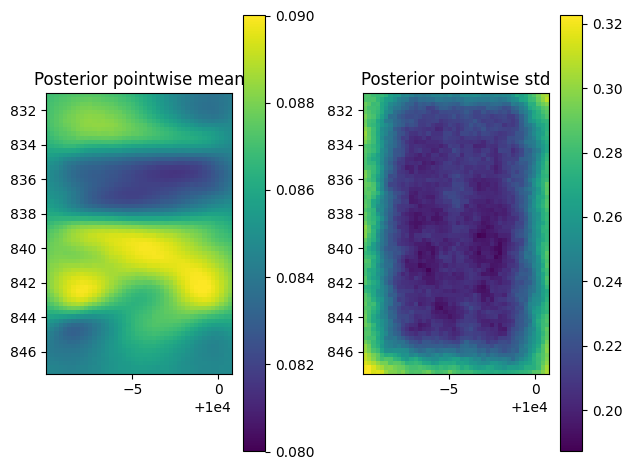

In [9]:
m_post_mean = np.mean(m_post, axis=2)
m_post_std = np.std(1/m_post, axis=2)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(m_post_mean, extent=[x[0], x[-1], y[-1], y[0]])
plt.title('Posterior pointwise mean')
#plt.gca().invert_yaxis()
plt.clim(0.08, 0.09)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(m_post_std, extent=[x[0], x[-1], y[-1], y[0]])
plt.title('Posterior pointwise std')
#plt.gca().invert_yaxis()
plt.colorbar()
plt.tight_layout()
plt.show()

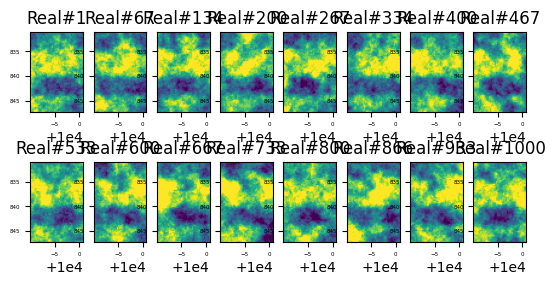

In [10]:
plt.figure()
iplot = np.linspace(1, m_post.shape[2], 16, dtype=int)
for i in range(len(iplot)):
    plt.subplot(3, 8, i+1)
    plt.imshow(m_post[:, :, iplot[i]-1], extent=[x[0], x[-1], y[0], y[-1]])
    plt.title(f'Real#{iplot[i]}')
    plt.gca().invert_yaxis()
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.clim(0.08, 0.09)
plt.savefig(f'boise_post_reals_{iplot[0]}_{iplot[-1]}.png')

P(TWIP > 30) = 0.35


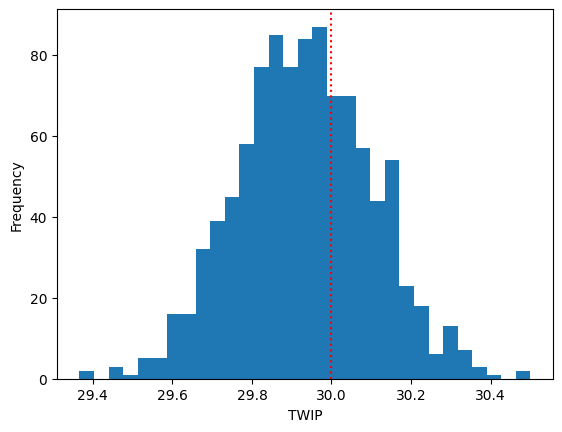

In [11]:
iy = np.where(y < 844)[0]
dxy = (x[1] - x[0]) * (y[1] - y[0])
TWIP = np.zeros(m_post.shape[2])
for i in range(m_post.shape[2]):
    por = np.exp(m_post[:, :, i] * (-41.7) + 2.03)
    TWIP[i] = np.sum(dxy * por[iy, :])

TWIP_lev = 30
plt.figure()
plt.hist(TWIP, bins=31)
plt.axvline(TWIP_lev, color='r', linestyle=':')
plt.xlabel('TWIP')
plt.ylabel('Frequency')
plt.savefig('boise_lsq_twip.png')

ip = np.where(TWIP > TWIP_lev)[0]
Ptwip = len(ip) / m_post.shape[2]
print(f'P(TWIP > {TWIP_lev}) = {Ptwip:.2f}')